In [1]:
import pandas as pd
import zipfile
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import sys
import scipy
import sklearn 
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import urllib
import scipy.cluster as scp
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Retrieve the zipcode shapefile 
urllib.request.urlretrieve('https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip','zips.gz')

('zips.gz', <http.client.HTTPMessage at 0x7f2e301bc390>)

In [3]:
#Move it to PUIDATA
!mv zips.gz $PUIDATA

In [4]:
#Unzip file.gz
zip_ref = zipfile.ZipFile(os.getenv("PUIDATA") + '/zips.gz', 'r')
zip_ref.extractall(os.getenv("PUIDATA"))
zip_ref.close()

In [5]:
#Read it in as a geodataframe
nyczipsshp = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + '/ZIP_CODE_040114.shp')
nyczipsshp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


Text(0.5,1,'Figure 1: NYC Zipcodes')

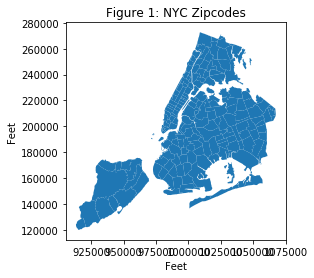

In [70]:
#Plot the data, rendering a map
ax = nyczipsshp.plot()
ax.set_xlabel('Feet')
ax.set_ylabel('Feet')
ax.set_title('Figure 1: NYC Zipcodes')

Figure 1 shows the zipcodes boundaries across NYC.

Text(0.5,1,'Figure 2: NYC Zipcodes after Cleaning')

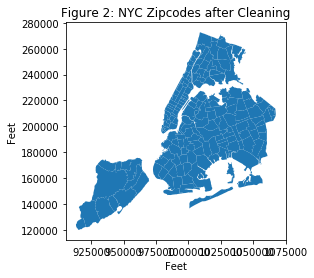

In [72]:
#Remove duplicates from the zipcode column and plot again
ax = nyczipsshp.drop_duplicates("ZIPCODE").plot()
ax.set_xlabel('Feet')
ax.set_ylabel('Feet')
ax.set_title('Figure 2: NYC Zipcodes after Cleaning')

Figure 2 shows the same zipcodes as figure one, but in order to reduce the chances of error later on, duplicates were removed. This was because the neighborhood of Marble Hill is part of New York County (i.e Manhattan) and is grouped with a Manhattan zipcode. However, it is disjointed and connected to the bronx. In order to have the shapefile render without two of the same zipcodes showing, Marble Hill had to be dropped. 

In [8]:
#Removing the duplicates reason, which ends up being marble hill, which is a neighborhood of New York County in the 
#Bronx
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


# Get zip data from her REPO

In [9]:
#Create an array of numeric values found in the file names
numbers1 = list(range(15))
numbers2 = [94, 95, 96, 97, 98, 99]
numbers_list  = numbers1 + numbers2
numbers_list = pd.Series(numbers_list).astype(str)
numbers_list = numbers_list.str.zfill(2)

In [10]:
#Create an emmpty data frame
csb = pd.DataFrame()

#Create a forloop that populates csb with the data collected from each of the census data files from FBB55 github page
for i in numbers_list.values:
    urllib.request.urlretrieve('https://github.com/fedhere/PUI2018_fb55/blob/master/HW12_fb55/zbp'+ i + 'totals.zip?raw=true',
                               'file.gz')
    !mv file.gz $PUIDATA
    zip_ref = zipfile.ZipFile(os.getenv("PUIDATA") + '/file.gz', 'r')
    zip_ref.extractall(os.getenv("PUIDATA"))
    zip_ref.close()
    readin_file = pd.read_csv(os.getenv('PUIDATA') + '/zbp' + i + 'totals.txt', dtype = 'object')
    readin_file['year'] = i
    csb = pd.concat([csb,readin_file], axis = 0)

In [11]:
#Map the year code to a numeric year
code_to_year = {'00': 2000,'01': 2001, '02': 2002, '03': 2003, '04': 2004, '05': 2005, '06': 2006, '07': 2007, '08': 2008, '09': 2009, '10': 2010, '11': 2011, '12': 2012, '13': 2013, '14': 2014, '15': 2015, '94': 1994, '95': 1995, '96': 1996, '97': 1997, '98': 1998, '99': 1999 }
csb['year'] = csb['year'].map(code_to_year)
csb.head()

,AP,EMP,EMPFLAG,EST,NAME,QP1,ZIP,ap,ap_nf,city,...,emp,emp_nf,empflag,est,name,qp1,qp1_nf,stabbr,year,zip
0,0,0,A,1,"HOLTSVILLE, NY",0,00501,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,NaN
1,259661,8042,NaN,493,"AGAWAM, MA",59833,01001,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,NaN
2,169658,6547,NaN,563,"AMHERST, MA",36719,01002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,NaN
3,2482,82,NaN,13,"AMHERST, MA",308,01003,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,NaN
4,5826,717,NaN,48,"AMHERST, MA",2049,01004,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,NaN


In [12]:
#Due to duplicate columns, data from rows of lower case columns was taken to populate corresponding NaNs in upper 
#case columns 
csb['ZIP'] = csb.ZIP.fillna(csb['zip'])
csb['NAME'] = csb.NAME.fillna(csb['name'])
csb['EST'] = csb.EST.fillna(csb['est'])
csb['EMP'] = csb.EMP.fillna(csb['emp'])
csb['EMPFLAG'] = csb.EMPFLAG.fillna(csb['empflag'])
csb['AP'] = csb.AP.fillna(csb['ap'])
csb['QP1'] = csb.QP1.fillna(csb['qp1'])

In [13]:
#Limiting the data we want
csb_final = csb[['ZIP','EST','year']]
csb_final.head()

,ZIP,EST,year
0,00501,1,2000
1,01001,493,2000
2,01002,563,2000
3,01003,13,2000
4,01004,48,2000


In [14]:
#Turning EST into values
csb_final['EST'] = csb_final['EST'].astype(int)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [15]:
# Unstacking allows for the years to become rows
csb_gb = csb_final.groupby(['ZIP', 'year'])['EST'].sum().unstack().reset_index()
csb_gb.head()

year,ZIP,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,00501,NaN,2.0,4.0,4.0,3.0,2.0,1.0,6.0,11.0,...,2.0,8.0,5.0,3.0,2.0,2.0,2.0,2.0,2.0,4.0
1,01000,NaN,4.0,11.0,8.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01001,439.0,439.0,433.0,457.0,444.0,469.0,493.0,490.0,490.0,...,509.0,509.0,503.0,477.0,458.0,448.0,436.0,453.0,439.0,458.0
3,01002,450.0,467.0,487.0,500.0,490.0,558.0,563.0,587.0,566.0,...,589.0,582.0,596.0,584.0,571.0,570.0,558.0,572.0,572.0,560.0
4,01003,10.0,10.0,13.0,15.0,14.0,13.0,13.0,13.0,15.0,...,12.0,12.0,16.0,17.0,16.0,16.0,16.0,15.0,15.0,18.0


In [16]:
#Merge the EST data with the geodataframe
csb_merge = nyczipsshp.merge(csb_gb, left_on = 'ZIPCODE', right_on = 'ZIP', how = 'left')

In [17]:
#Find the shape of the dataframe
csb_merge.shape

(263, 35)

In [18]:
#Turn zipcode into a float
csb_merge['ZIPCODE'] = csb_merge['ZIPCODE'].astype(float)

In [19]:
#Clean the data set and set the zipcode as the axis
csb_nyc_cleaned = csb_merge.drop(['BLDGZIP','PO_NAME','POPULATION','AREA','STATE','COUNTY','ST_FIPS','CTY_FIPS','URL','SHAPE_AREA','SHAPE_LEN','ZIP','geometry'], axis = 1)
csb_nyc_cleaned.index = csb_nyc_cleaned['ZIPCODE']
csb_nyc_cleaned.drop(['ZIPCODE'], axis = 1, inplace = True)

In [20]:
csb_nyc_cleaned.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436.0,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,74.0,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0
11213.0,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,569.0,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0
11212.0,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,581.0,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0
11225.0,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,488.0,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0
11218.0,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,1247.0,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0


In [21]:
#Further cleaning
est_by_year = csb_nyc_cleaned.dropna(axis = 0, how = 'any')

In [22]:
est_by_year.shape

(243, 21)

In [23]:
#Normalize the EST data
vals = ((est_by_year.T - est_by_year.mean(1)) / est_by_year.std(1)).T

In [24]:
#Shape of the data
vals.shape

(243, 21)

In [25]:
#print(vals.mean(axis=1))
#print(vals.mean(axis=1).shape)
#print(vals.std(axis = 1))

At 2 clusters, inertia is 1549.9204448610353
At 3 clusters, inertia is 1344.683388124492
At 4 clusters, inertia is 1171.0024212331177
At 5 clusters, inertia is 1063.6739415455359
At 6 clusters, inertia is 985.0466055423639
At 7 clusters, inertia is 924.0673107294443
At 8 clusters, inertia is 880.0822473508156
At 9 clusters, inertia is 836.0409620622202


Text(0.5,1,'Figure 3: Inertia Plot')

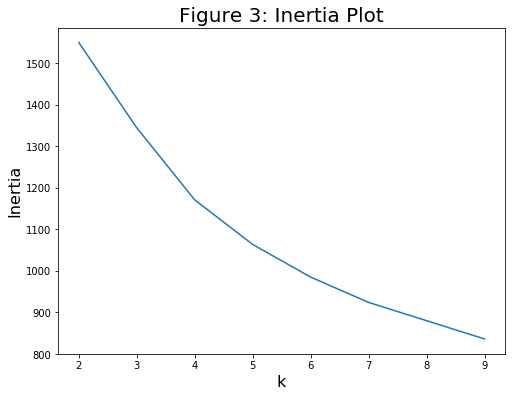

In [26]:
#got this from Andrew Hill. Shows where the bend is to determine how many clusters to choose for our analysis
s = np.zeros(8)
for k in range(0, 8):
   est = KMeans(n_clusters = k+2, n_init = 100)
   est.fit(vals)
   s[k] = est.inertia_
   print('At {0} clusters, inertia is {1}'.format(k+2, s[k]))
   
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), s,'-')
plt.xlabel('k', fontsize = 16)
plt.ylabel('Inertia', fontsize = 16)
plt.title('Figure 3: Inertia Plot', fontsize = 20)

Figure 3 is an intertia plot for k means clustering. Here we are looking for an optimal amount of clusters based on the corresponding initeria. By doing that, we must search for the 'elbow' of the graph, which is found at k = 4.

In [27]:
# Perform the k means clustering 
km = KMeans(n_clusters=4, random_state=444).fit(vals)
km.labels_.shape

(243,)

In [28]:
#Populate a column with corresponding cluster IDs for each zipcode 
est_by_year['cluster_groups'] = km.labels_
est_by_year.cluster_groups.value_counts()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


0    178
1     31
3     18
2     16
Name: cluster_groups, dtype: int64

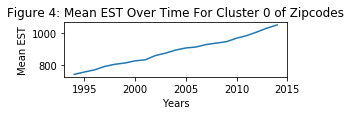

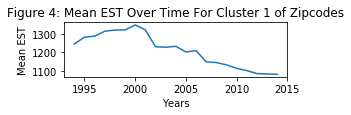

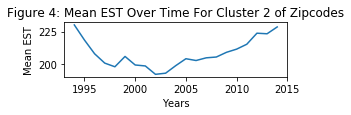

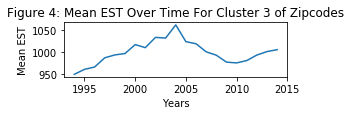

In [29]:
#Plot each of the average EST per each of the clustered zipcodes over time
for i in range(4):
    fig = plt.figure(figsize = (4,1))
    ax = fig.add_subplot(111)
    grp = est_by_year[est_by_year['cluster_groups'] == i]
    grp = grp.drop(['cluster_groups'], axis =1)
    ax.plot(grp.mean(axis = 0), '-')
    ax.set_xlabel('Years')
    ax.set_ylabel('Mean EST')
    ax.set_title('Figure 4: Mean EST Over Time For Cluster {} of Zipcodes'.format(i,range(4)))

Figure 4 shows the four cluster's averages for their respective business estimates time series. In cluster 0, zipcodes have had estimate linearly rising, suggesting constant growth. Cluster 1 has a general decrease over time in business estimates, suggesting decline in growth. Cluster 2 had some decline in the late ninetees and early two thousands but has since rebounded. This cluster also has the fewest estimates of all the clusters, perhaps that it is a zipcode that is mostly residential or sparsely populated (such as JFK and Maspeth). Lastly there is cluster 3 which had a peak in 2004 of business growth, but has since declined, right around the time of the 2007 economic crash, which led to the 2008 recession. 

In [30]:
#Show the dataframe you are working with
est_by_year.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,cluster_groups
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436.0,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,74.0,...,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0,0
11213.0,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,569.0,...,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0,0
11212.0,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,581.0,...,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0,0
11225.0,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,488.0,...,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0,0
11218.0,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,1247.0,...,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0,0


In [31]:
#Reset the index to get zipcode data
est_by_zip = est_by_year.reset_index()

In [32]:
#See the dataframe you are working with
est_by_zip.head()

,ZIPCODE,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,cluster_groups
0,11436.0,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,...,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0,0
1,11213.0,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,...,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0,0
2,11212.0,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,...,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0,0
3,11225.0,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,...,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0,0
4,11218.0,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,...,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0,0


In [33]:
#Convert the shapefile zipcode to a float for merging
nyczipsshp['ZIPCODE'] = nyczipsshp['ZIPCODE'].astype(float)

In [34]:
#Merge the shapefile with the cluster data
est_merge = nyczipsshp.merge(est_by_zip, left_on = 'ZIPCODE', right_on = 'ZIPCODE')

In [35]:
#See the dataframe you are working with
est_merge.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,cluster_groups
0,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0,0
1,11213.0,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0,0
2,11212.0,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,...,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0,0
3,11225.0,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,...,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0,0
4,11218.0,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,...,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0,0


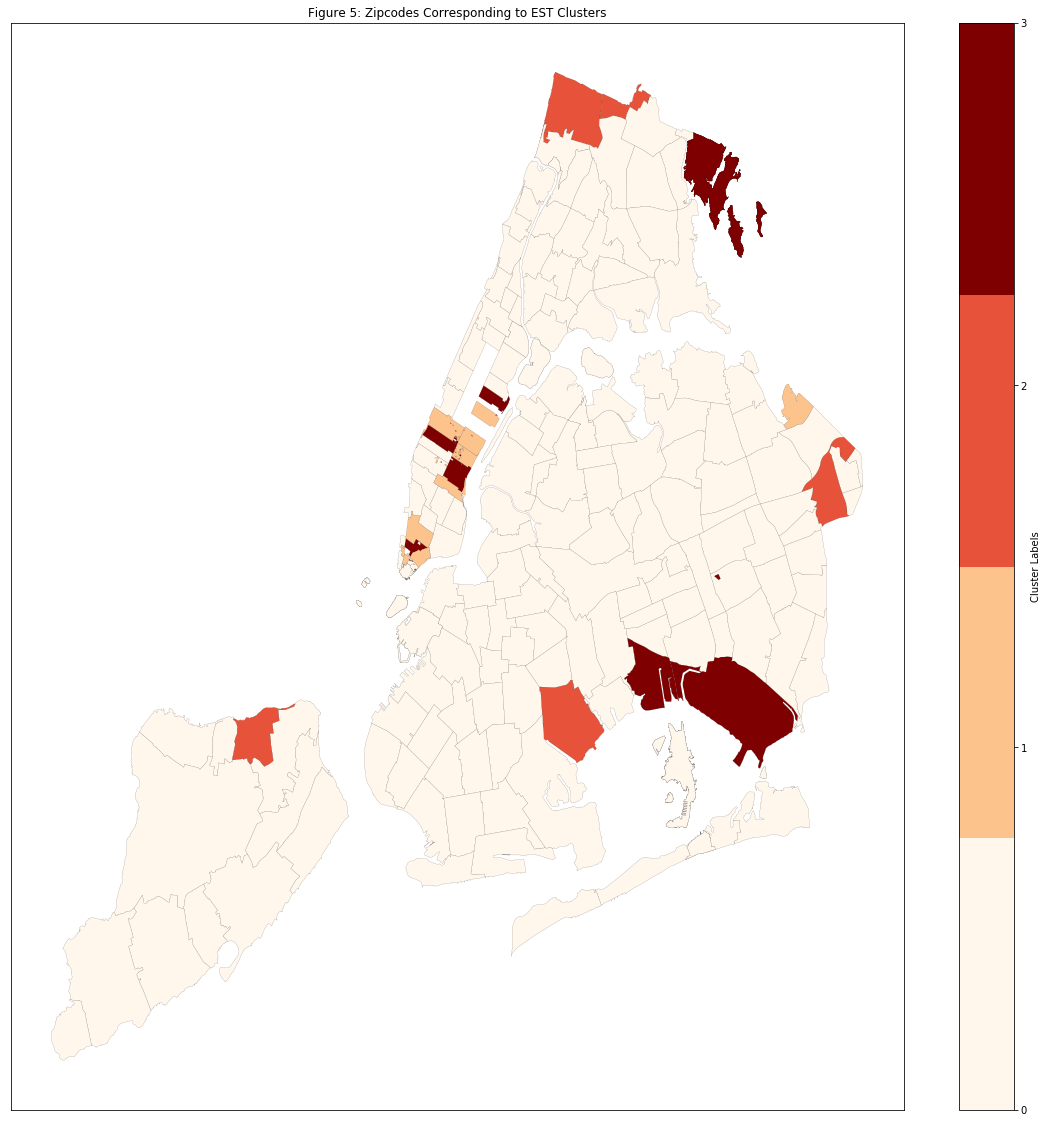

In [36]:
#Plot the zipcodes with a colormap depicting the different clusters. Remember Ursula for helping me with this
f, ax = plt.subplots(figsize=(20,20))
cmap = plt.cm.get_cmap('OrRd',4)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
base = est_merge.plot(column='cluster_groups',edgecolor = 'k',cmap=cmap,alpha=1,
                  linewidth=0.1,ax=ax, legend=False)
ax.set_title("Figure 5: Zipcodes Corresponding to EST Clusters")
norm = mpl.colors.Normalize(vmin = 0, vmax = 3)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
cb = plt.colorbar(sm, ticks = np.linspace(0,4,5))
cb.set_label('Cluster Labels')

Figure 5 displays the zipcodes of NYC according to their assigned clusters via k-means. For the most part NYC is pretty homogenous, having a cluster value of 0. This would suggest these zipcodes have similar business estimates for each year, where these estimates are growing in a linear fassion, as seen in figure 4's cluster 0 graph. Cluster 1, focussed mostly in Midtown, West Village, and Little Neck appear to have been losing business estimates over the year. Cluster two, consisting of North Staten Island, Canarsie, North Bronx, and far East Queens, appears to have a trough in business estimates in the early 2000s, but has since rebounded. Finally, cluster 3 consists of JFK, parts of Midtown, TriBeCa, and City Island. These zipcodes experienced a peak in business estimates, but has since fallen. 

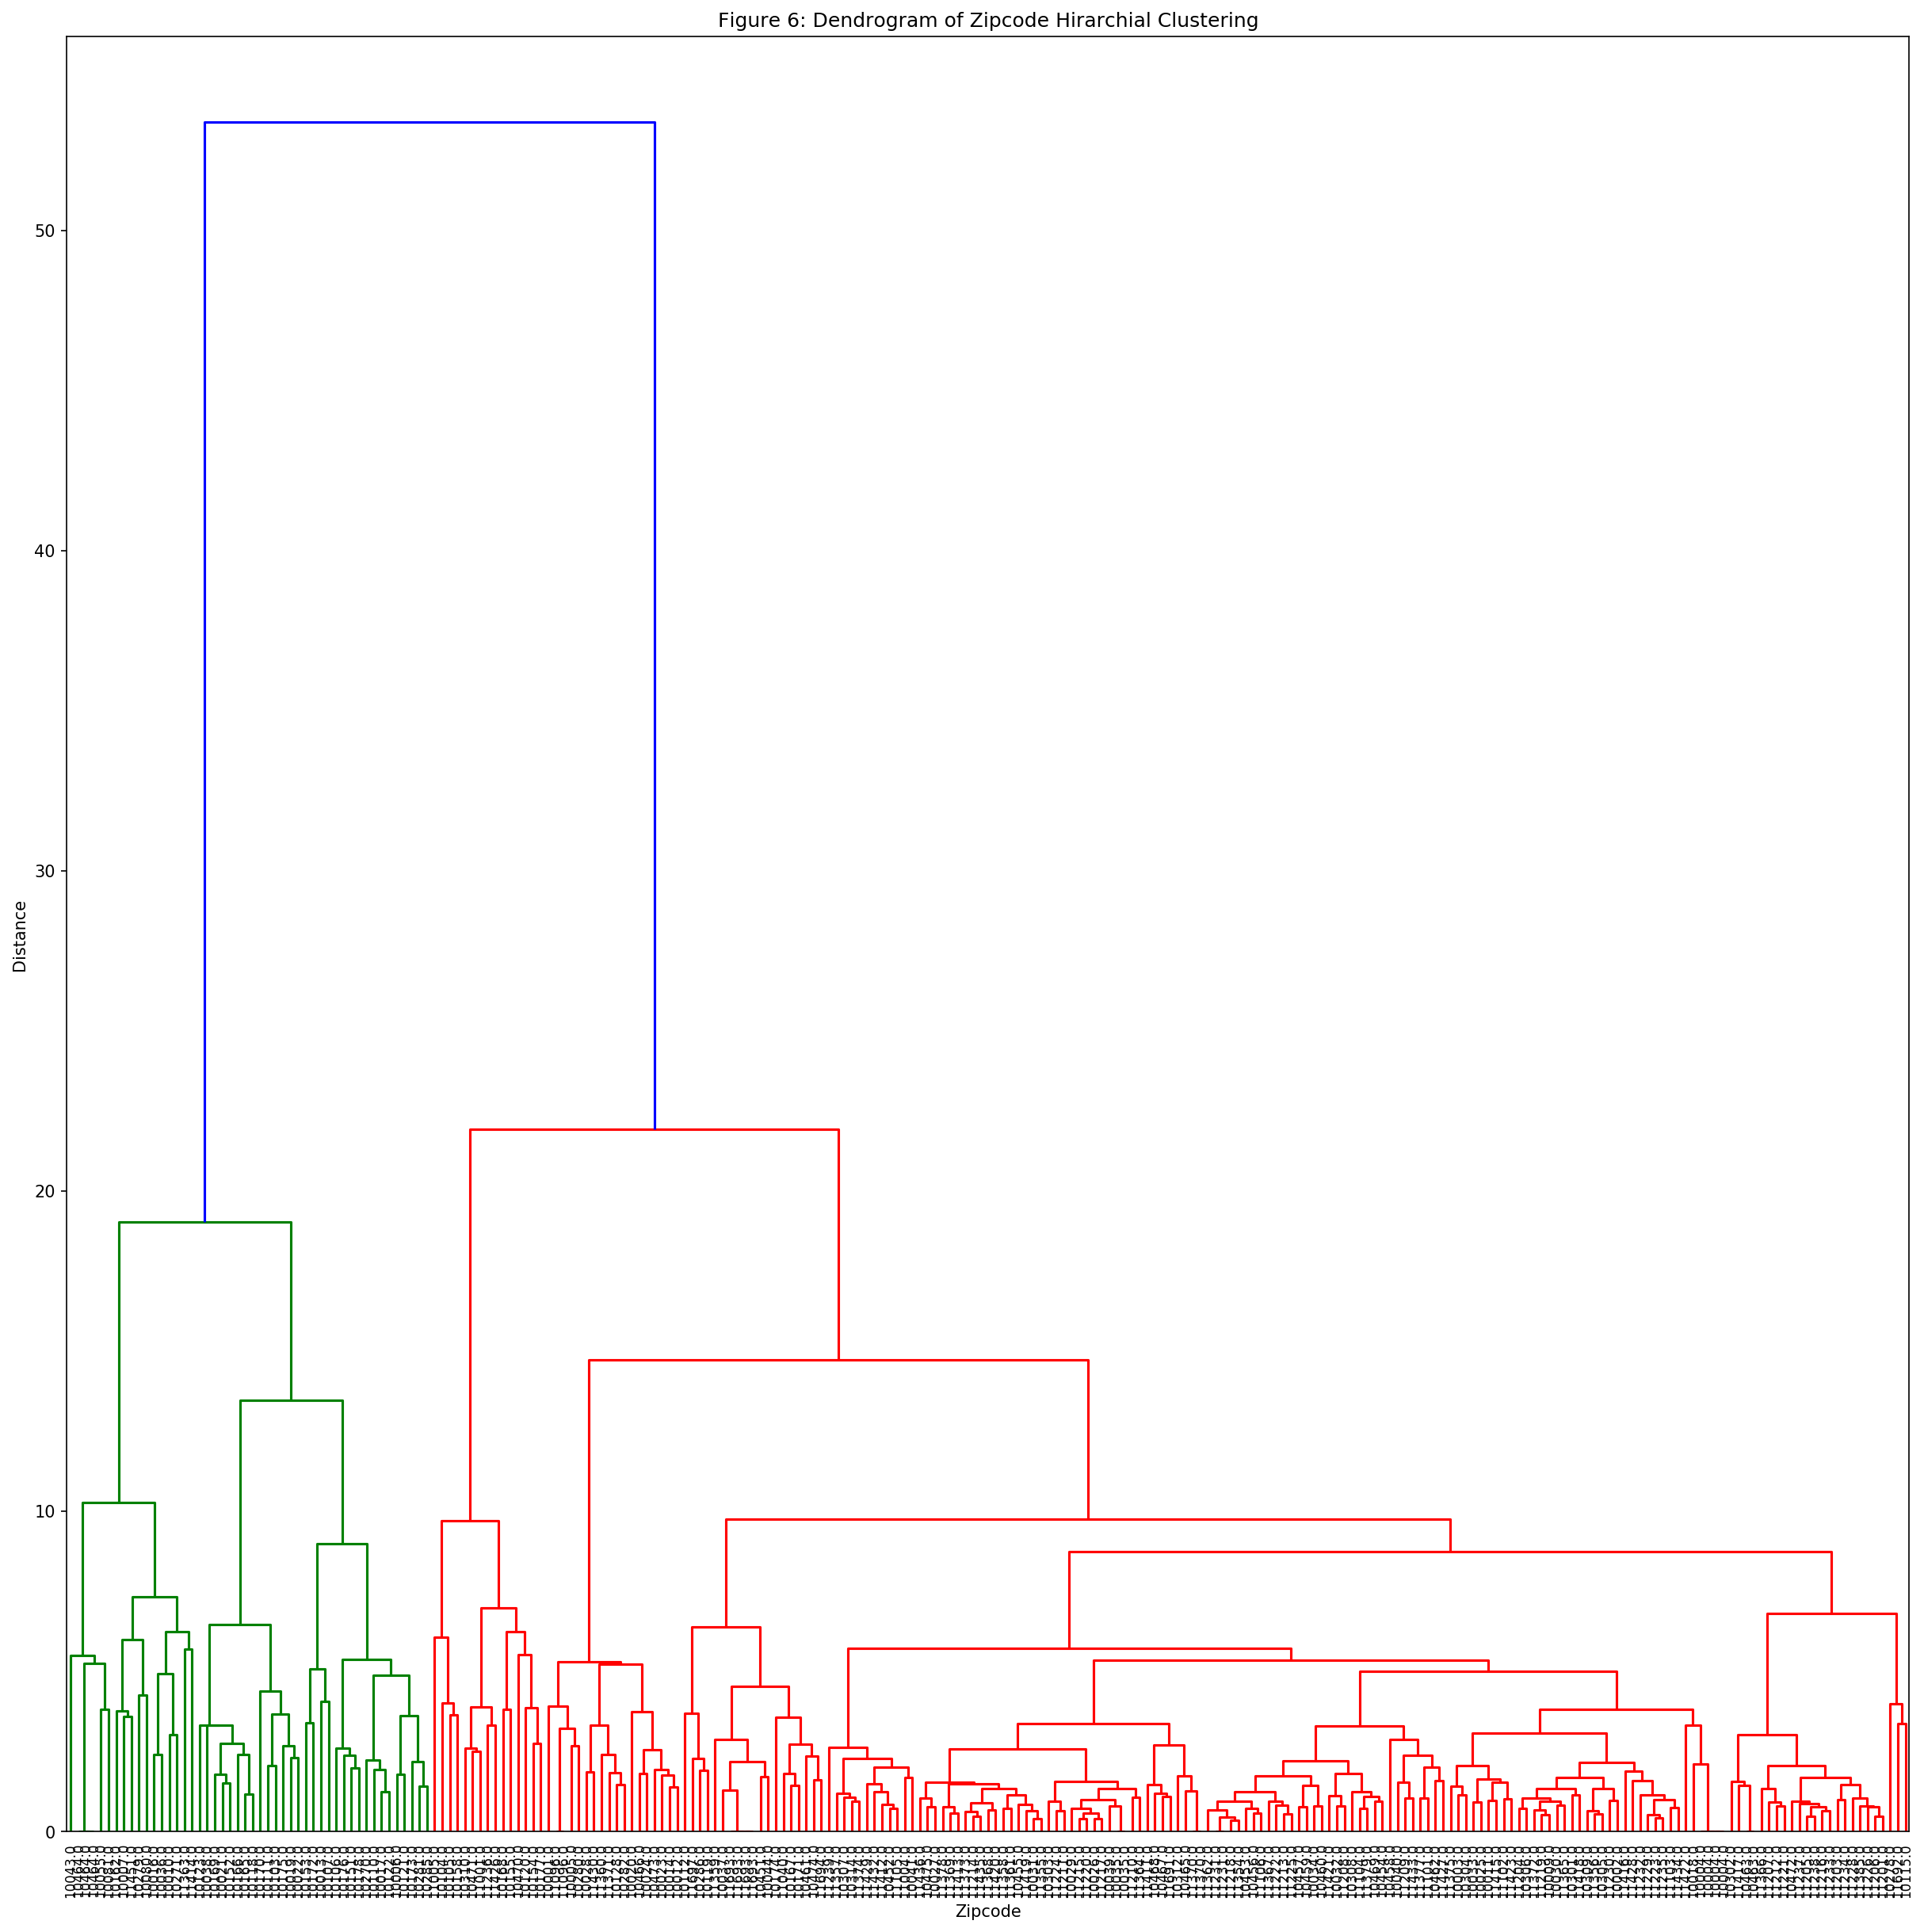

In [65]:
#Create a dendrogram of heirarchial clusters
fig = pl.figure(figsize=(20,20), dpi=150)
pl.xlabel("Zipcode")
pl.ylabel("Distance")
pl.title("Figure 6: Dendrogram of Zipcode Hirarchial Clustering")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals, method='ward'),
                               labels = est_by_year.index,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.)  # font size for the x axis labels)

Figure 6 shows the dendrogram of zipcode clusters. The distance is the disntance away between the zipcodes. Originally there is just one cluster (middle of the blue) and as more and more clusters begin to leaf off, you end up with a total of 243 clusters (each individual zip code).